In [5]:
%pip install pandas numpy matplotlib seaborn scikit-learn tensorflow keras cartopy

Note: you may need to restart the kernel to use updated packages.


In [6]:
%pip install kaggle kagglehub

Note: you may need to restart the kernel to use updated packages.


## Data Import

### We need to use Kaggle's API to download the data since it's too big to be uploaded to GitHub

In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("usdot/flight-delays")

print("Path to dataset files:", path)

Path to dataset files: /Users/naominayman/.cache/kagglehub/datasets/usdot/flight-delays/versions/1


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.compose import ColumnTransformer
from scipy.stats import pointbiserialr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from collections import OrderedDict
from sklearn.neural_network import MLPClassifier


In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential
# could be cool to do sometype of simple NN 

In [10]:
df = pd.read_csv(path + "/flights.csv")
airports = pd.read_csv(path + "/airports.csv")

/var/folders/78/46rnh6cd7w1dzd2t3dyd5t040000gn/T/ipykernel_58814/1086104120.py:1: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path + "/flights.csv")


In [11]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


## Data Cleaning

In [12]:
df.DEPARTURE_DELAY = df.DEPARTURE_DELAY.dropna() # drop NaN
df.ARRIVAL_DELAY = df.ARRIVAL_DELAY.dropna() # drop NaN

In [13]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


### We need to decide how long the departure/arrival delay needs to be to classify as a significant delay

This is just my data exploration

In [14]:
df.DEPARTURE_DELAY.describe(), df.ARRIVAL_DELAY.describe()

(count    5.732926e+06
 mean     9.370158e+00
 std      3.708094e+01
 min     -8.200000e+01
 25%     -5.000000e+00
 50%     -2.000000e+00
 75%      7.000000e+00
 max      1.988000e+03
 Name: DEPARTURE_DELAY, dtype: float64,
 count    5.714008e+06
 mean     4.407057e+00
 std      3.927130e+01
 min     -8.700000e+01
 25%     -1.300000e+01
 50%     -5.000000e+00
 75%      8.000000e+00
 max      1.971000e+03
 Name: ARRIVAL_DELAY, dtype: float64)

In [15]:
df.DEPARTURE_DELAY.value_counts().sort_index()

DEPARTURE_DELAY
-82.0      1
-68.0      1
-61.0      1
-56.0      1
-55.0      1
          ..
 1631.0    1
 1649.0    1
 1670.0    1
 1878.0    1
 1988.0    1
Name: count, Length: 1217, dtype: int64

In [16]:
df.ARRIVAL_DELAY.value_counts().sort_index()

ARRIVAL_DELAY
-87.0      2
-82.0      1
-81.0      2
-80.0      3
-79.0      2
          ..
 1636.0    2
 1638.0    1
 1665.0    1
 1898.0    1
 1971.0    1
Name: count, Length: 1240, dtype: int64

In [17]:
len(df.columns)

31

## Plot airports on a map and maybe cluster based on geographic location

In [18]:
airports.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


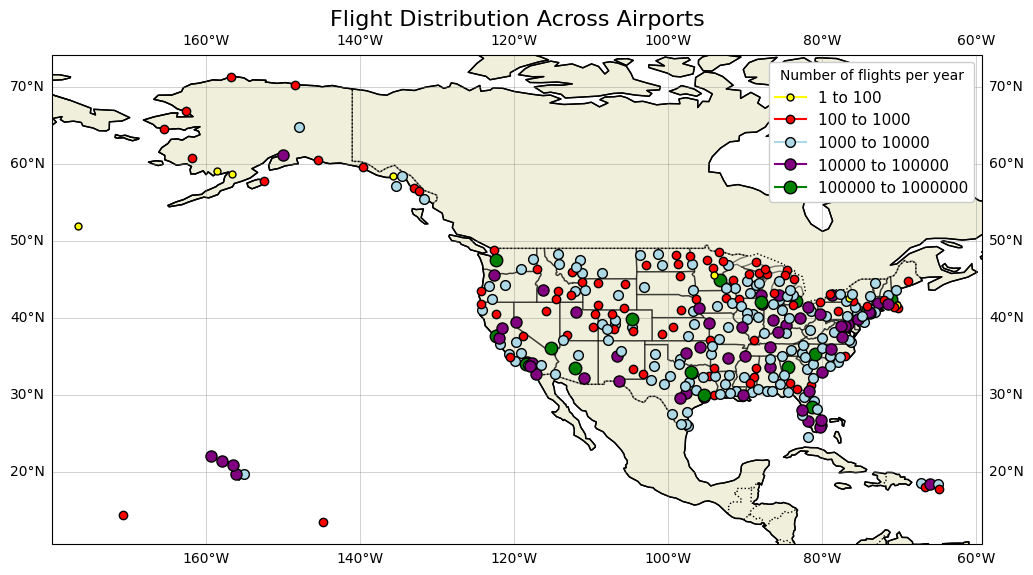

In [19]:
count_flights = df['ORIGIN_AIRPORT'].value_counts()
colors = ['yellow', 'red', 'lightblue', 'purple', 'green', 'orange']
size_limits = [1, 100, 1000, 10000, 100000, 1000000]
labels = []

for i in range(len(size_limits)-1):
    labels.append(f"{size_limits[i]} to {size_limits[i+1]}")

# Create a figure with a geographic projection
plt.figure(figsize=(12, 12))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add features to the map
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle='-', alpha=0.5)

ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)

# Plot airports on the map
for index, (code, y, x) in airports[['IATA_CODE', 'LATITUDE', 'LONGITUDE']].iterrows():
    isize = [i for i, val in enumerate(size_limits) if val < count_flights.get(code, 0)]
    if isize:  # Check if the airport has flight counts within defined limits
        ind = isize[-1]
        ax.plot(x, y, marker='o', markersize=ind+5, markeredgewidth=1, 
                color=colors[ind], markeredgecolor='k', 
                transform=ccrs.PlateCarree(), label=labels[ind])


handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
key_order = ('1 to 100', '100 to 1000', '1000 to 10000',
             '10000 to 100000', '100000 to 1000000')
new_label = OrderedDict()
for key in key_order:
    if key in by_label:
        new_label[key] = by_label[key]

# Add a legend
plt.legend(new_label.values(), new_label.keys(), loc='upper right', prop={'size':11},
           title='Number of flights per year', frameon=True, framealpha=1)

# Show the map
plt.title("Flight Distribution Across Airports", fontsize=16)
plt.show()

## Airport location grouping by west coast, midwest, east coast, south


In [20]:
#joining on origin airport
df = df.join(airports.set_index('IATA_CODE'), on='ORIGIN_AIRPORT', how='inner')


In [21]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,San Francisco International Airport,San Francisco,CA,USA,37.61900,-122.37484
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Seattle-Tacoma International Airport,Seattle,WA,USA,47.44898,-122.30931


In [22]:
def group_states(row):
    if row in ['CA', 'WA', 'OR', 'AK', 'HI', 'AZ', 'NV', 'UT', 'ID', 'MT', 'WY', 'CO', 'NM']:
        return 'west'
    elif row in ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO', 'WI', 'IL', 'IN', 'MI', 'OH']:
        return 'midwest'
    elif row in ['TX', 'OK', 'AR', 'LA', 'MS', 'AL', 'GA', 'FL', 'SC', 'NC', 'TN', 'KY']:
        return 'south'
    elif row in ['PA', 'NY', 'NJ', 'CT', 'RI', 'MA', 'NH', 'VT', 'ME', 'DE', 'MD', 'VA', 'WV', 'DC']:
        return 'east'
    else:
        return 'Other'

In [23]:
# group origin airport states into regions
df['OA_grouped'] = df['STATE'].map(group_states)

In [24]:
#remove join on airports and origin airport
df.drop(['AIRPORT', 'CITY','STATE', 'COUNTRY', 'LATITUDE', "LONGITUDE"], axis=1, inplace=True)

In [25]:
#now join on destination airport
df = df.join(airports.set_index('IATA_CODE'), on='DESTINATION_AIRPORT', how='inner')

In [26]:
# map destination airport states into regions
df['DA_grouped'] = df['STATE'].map(group_states)

In [27]:
# remove airport information since we don't need it anymore
df.drop(['AIRPORT', 'CITY','STATE', 'COUNTRY', 'LATITUDE', "LONGITUDE"], axis=1, inplace=True)

In [28]:
# now we have grouped airport regions so one hot encoding them will be much easier
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,OA_grouped,DA_grouped
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,west,west
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,west,south
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,west,south
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,west,south
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,west,west


## Create the target variable by classifying significant delay as a delay that lasts longer than 10 mins

In [29]:
# create the target variable
df['target'] = (
    (df['ARRIVAL_DELAY'] > 0) |
    (df['DEPARTURE_DELAY'] > 0) |
    (df['CANCELLED'] == 1) |
    (df['DIVERTED'] == 1) |
    (df['AIR_SYSTEM_DELAY'] > 0) |
    (df['SECURITY_DELAY'] > 0) |
    (df['AIRLINE_DELAY'] > 0) |
    (df['LATE_AIRCRAFT_DELAY'] > 0) |
    (df['WEATHER_DELAY'] > 0))

df.target = df.target.astype(int)

In [30]:
# The target variable classes are more or less balanced so we don't need to worry about class imbalance
df.target.value_counts()

target
0    2730045
1    2602869
Name: count, dtype: int64

## Feature selection and correlation testing

### Feature handling/scaling

In [31]:
# Month, Day, Day of Week, and Scheduled Departure are cyclic features, need to create sin and cos features

def calc_sin(feature):
    return np.sin(2 * np.pi * feature) 

def calc_cos(feature):
    return np.cos(2 * np.pi * feature)

In [32]:
df['month_sin'] = calc_sin((df.MONTH - 1) / 12)
df['month_cos'] = calc_cos((df.MONTH - 1) / 12)
df['day_sin'] = calc_sin((df.DAY - 1) / 31)
df['day_cos'] = calc_cos((df.DAY - 1) / 31)
df['dow_sin'] = calc_sin((df.DAY_OF_WEEK - 1) / 7)
df['dow_cos'] = calc_cos((df.DAY_OF_WEEK - 1) / 7)
df['hour_sin'] = calc_sin((df.SCHEDULED_DEPARTURE) / 24)
df['hour_cos'] = calc_cos((df.SCHEDULED_DEPARTURE) / 24)

In [33]:
features = ['month_sin', 'month_cos', 'day_sin', 'day_cos', 'dow_sin', 'dow_cos', 'hour_sin', 'hour_cos', 'AIRLINE', 'OA_grouped', 'DA_grouped']
cat_features = ['AIRLINE', 'OA_grouped', 'DA_grouped']
num_features = ['month_sin', 'month_cos', 'day_sin', 'day_cos', 'dow_sin', 'dow_cos', 'hour_sin', 'hour_cos']

### Categorical Feature Correlation Testing - Chi-Squared

In [34]:
# one hot encode the categorical variables and drop numeric values just for correlation testing
ct = ColumnTransformer([('OHE', OneHotEncoder(), ['AIRLINE', 'OA_grouped', 'DA_grouped'])], remainder='drop')

# we'll sample the data to make it faster to work with
df_sample = df.sample(frac=0.4, replace=False, random_state=42)

chi_features_ohe = ct.fit_transform(df_sample[features])

In [35]:
chi2_stats, p_values = chi2(chi_features_ohe, df_sample['target'])

chi2_results = pd.DataFrame({
    'Feature': ct.get_feature_names_out(),
    'Chi2 Statistic': chi2_stats,
    'P-Value': p_values
})

chi2_results

,Feature,Chi2 Statistic,P-Value
0,OHE__AIRLINE_AA,301.976392,1.222325e-67
1,OHE__AIRLINE_AS,1613.600513,0.000000e+00
2,OHE__AIRLINE_B6,31.467115,2.028467e-08
3,OHE__AIRLINE_DL,5642.311888,0.000000e+00
4,OHE__AIRLINE_EV,553.998574,1.698805e-122
5,OHE__AIRLINE_F9,329.987187,9.673376e-74
6,OHE__AIRLINE_HA,335.929722,4.912700e-75
7,OHE__AIRLINE_MQ,17.137258,3.477343e-05
8,OHE__AIRLINE_NK,1714.595064,0.000000e+00
9,OHE__AIRLINE_OO,979.912287,4.174984e-215


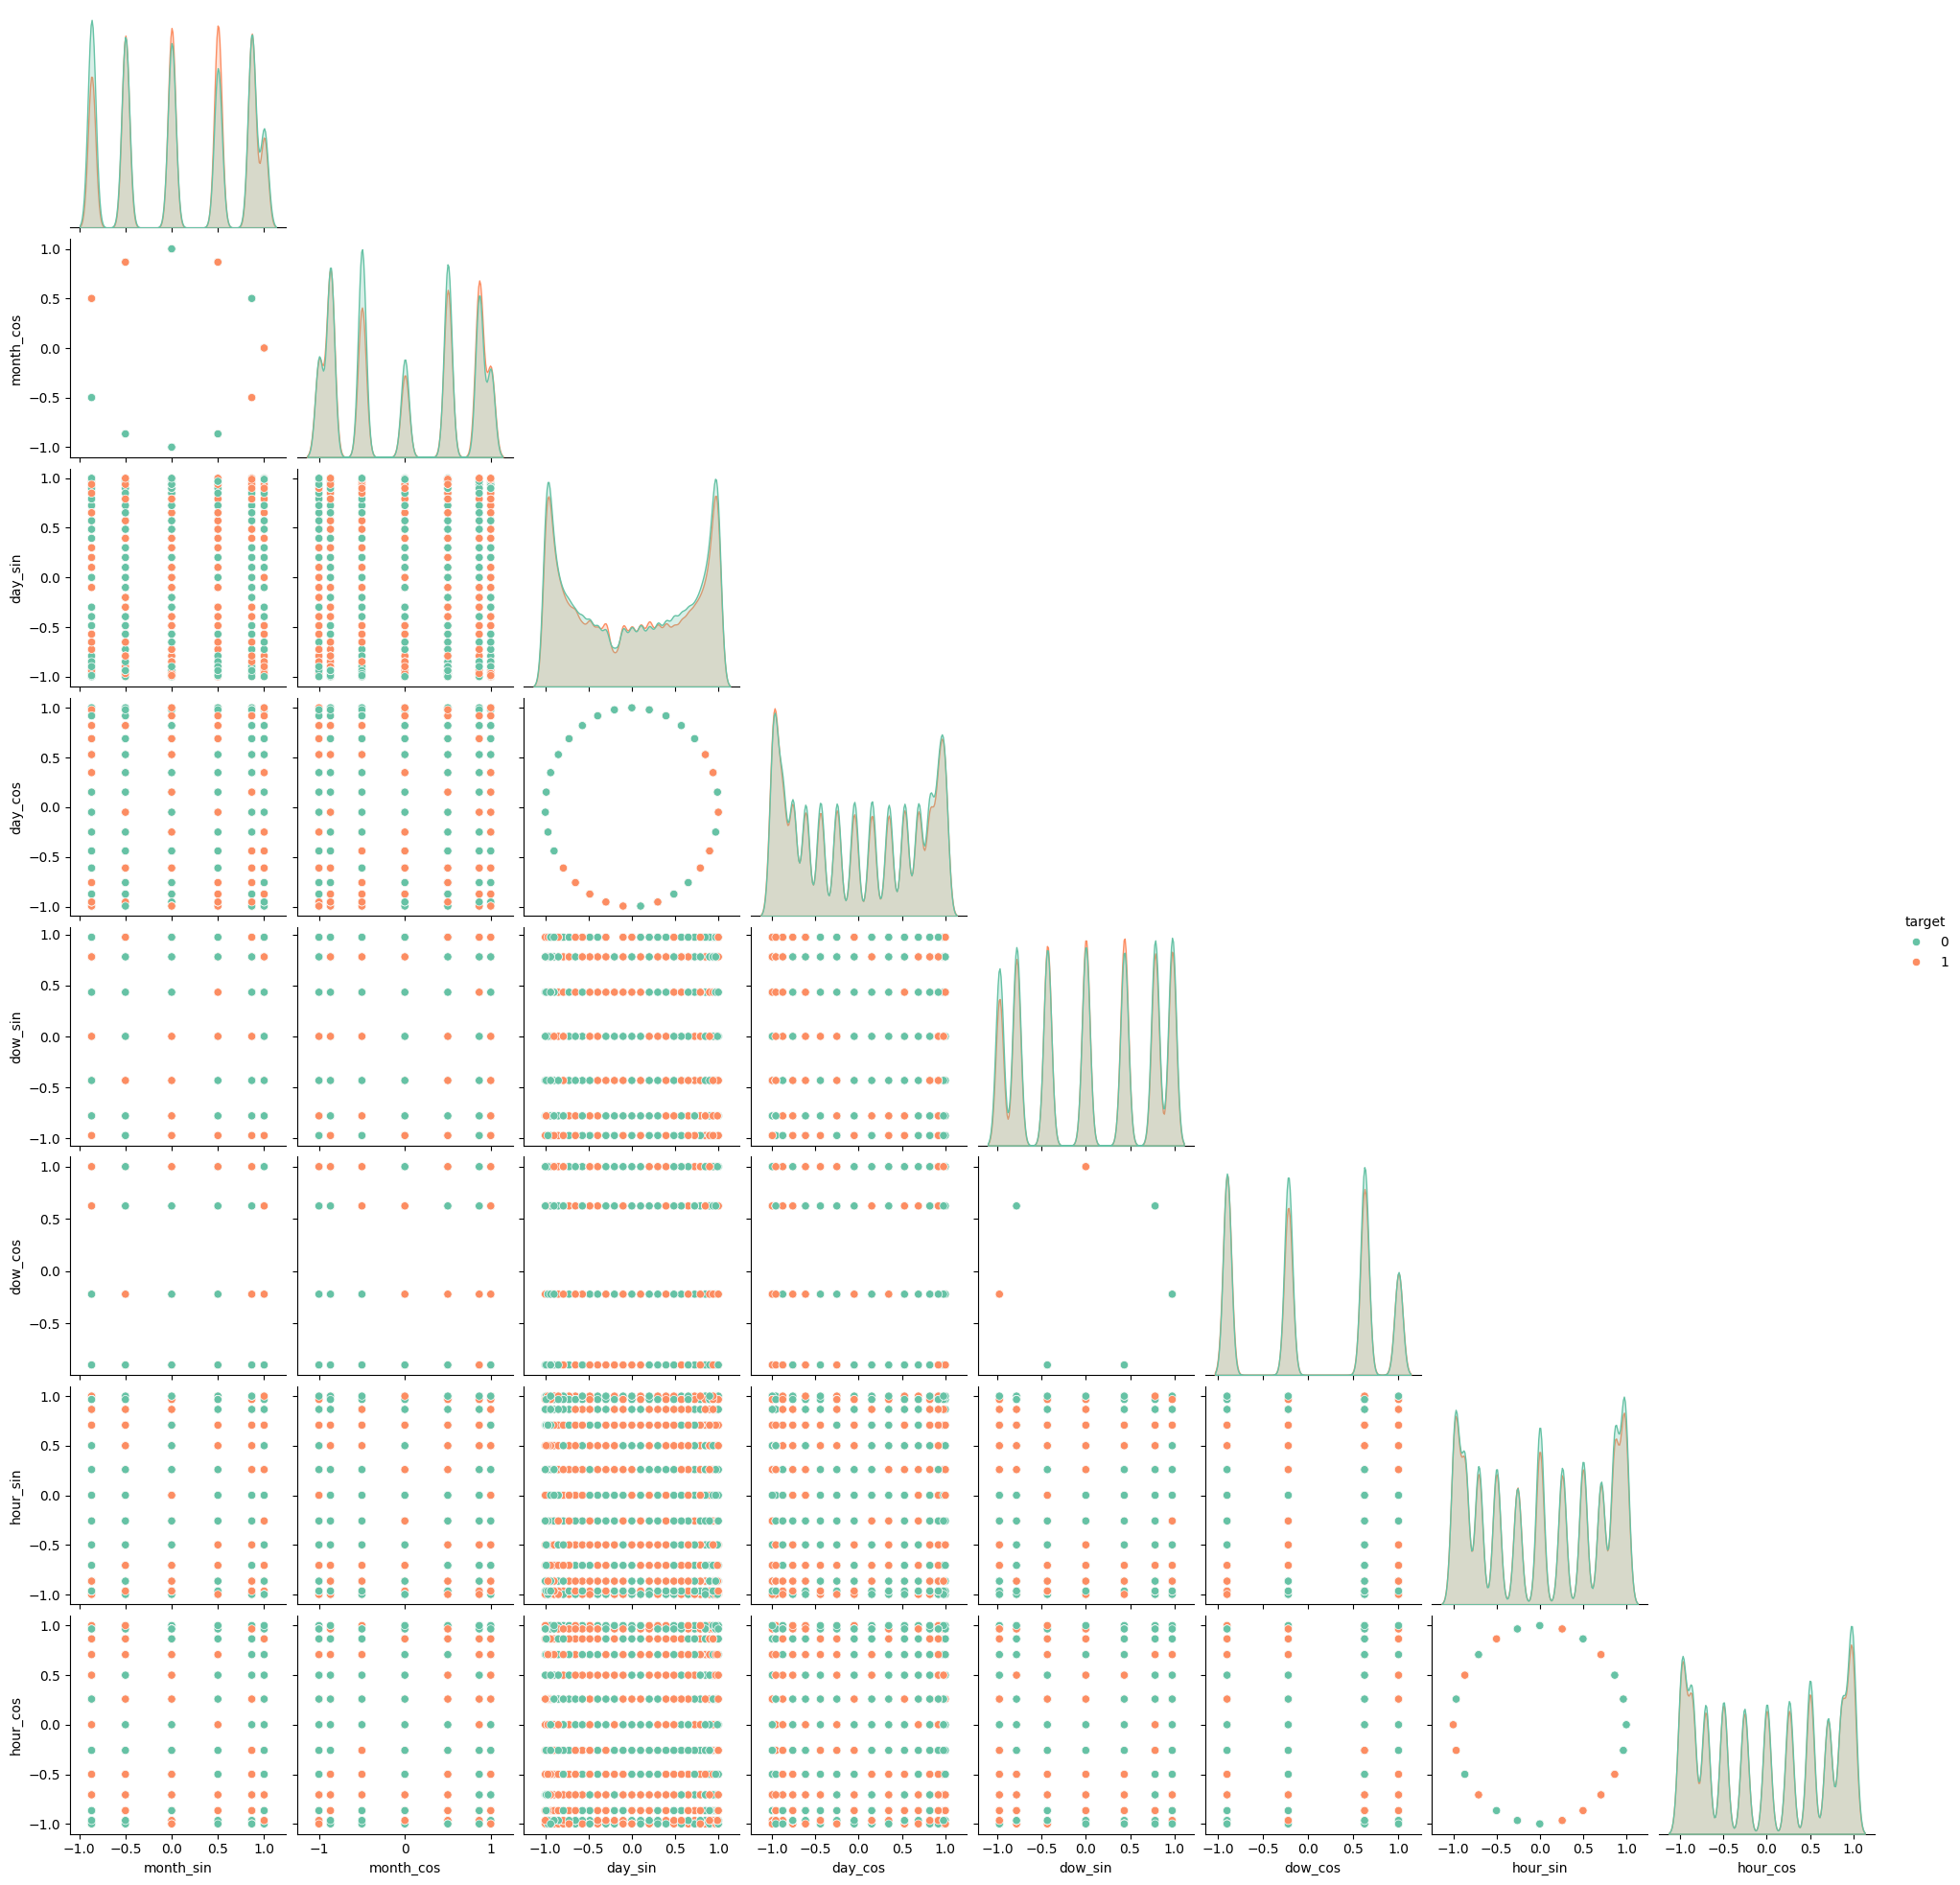

In [36]:
####### DO NOT RUN THIS CELLLLLLLLLL ########
df_numeric = df_sample[num_features + ['target']]

sns.pairplot(df_numeric, hue='target', diag_kind='kde', corner=True, palette='Set2')

plt.show()

### Point-Biserial Correlation between numerical features and binary target classification

In [37]:
correlations = {}
for feature in num_features:
    corr, p_value = pointbiserialr(df_sample[feature], df_sample['target'])
    correlations[feature] = (corr, p_value)

correlation_df = pd.DataFrame(correlations, index=['Correlation', 'P-Value']).T
correlation_df


,Correlation,P-Value
month_sin,0.044765,0.000000e+00
month_cos,0.021912,8.821639e-225
day_sin,-0.005131,6.682312e-14
day_cos,-0.007900,8.451240e-31
dow_sin,0.011272,6.656324e-61
dow_cos,-0.007545,3.048718e-28
hour_sin,-0.007015,1.228280e-24
hour_cos,-0.005795,2.598858e-17


### Mutual Information Correlation between numerical features and binary target classification

In [38]:
########## DO NOT RUN THIS CELL ##########

mutual_info = mutual_info_classif(df_sample[num_features], df_sample['target'])

mutual_info_df = pd.DataFrame({
    'Feature': num_features,
    'Mutual Information': mutual_info
}).sort_values(by='Mutual Information', ascending=False)

mutual_info_df

,Feature,Mutual Information
5,dow_cos,0.060168
1,month_cos,0.043837
0,month_sin,0.042116
4,dow_sin,0.035713
6,hour_sin,0.019045
7,hour_cos,0.016378
3,day_cos,0.013965
2,day_sin,0.007534


## Create a model and figure out the feature encoding

### Feature encoding: one hot encode categorical features, leave numerical features alone

In [39]:
# one hot encode the categorical variables
ct = ColumnTransformer([('OHE', OneHotEncoder(), ['AIRLINE', 'OA_grouped', 'DA_grouped']),
                        ('passthrough', 'passthrough', num_features)], remainder='passthrough')

features_ohe = ct.fit_transform(df_sample[features])

### First model - Decision Tree

In [40]:
tree = DecisionTreeClassifier()

# split the data
X_train, X_test, y_train, y_test = train_test_split(features_ohe, df_sample['target'], test_size=0.3, random_state=42)

# fit the model
tree.fit(X_train, y_train)


DecisionTreeClassifier()

In [41]:
y_pred_train = tree.predict(X_train)
print(f'Train Confusion Matrix:\n {confusion_matrix(y_train, y_pred_train)}') 
print(f'Train Precision: {precision_score(y_train, y_pred_train)}')
print(f'Train Recall: {recall_score(y_train, y_pred_train)}')
print(f'Train Accuracy: {accuracy_score(y_train, y_pred_train)}')
print(f'Train F1 Score: {f1_score(y_train, y_pred_train)}')

Train Confusion Matrix:
 [[671290  93407]
 [223499 505020]]
Train Precision: 0.8439124571585173
Train Recall: 0.6932145901479577
Train Accuracy: 0.7877694854595718
Train F1 Score: 0.7611764156190229


In [42]:
y_pred = tree.predict(X_test)
print(f'Test Confusion Matrix:\n {confusion_matrix(y_test, y_pred)}') 
print(f'Test Precision: {precision_score(y_test, y_pred)}')
print(f'Test Recall: {recall_score(y_test, y_pred)}')
print(f'Test Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Test F1 Score: {f1_score(y_test, y_pred)}')

Test Confusion Matrix:
 [[214171 113545]
 [163971 148263]]
Test Precision: 0.566304314612235
Test Recall: 0.47484578873537153
Test Accuracy: 0.5663473708883506
Test F1 Score: 0.5165580218869003


very high train accuracy and low test accuracy, high variance and low bias, suggesting the model is overfit

need to consider different data scaling techniques, such as one hot encoding for airlines and airports but a different method for month day scheduled departure and day of the week since they're not quite categorical or continuous 

### Hyper-parameter tuning using GridSearchCV

In [43]:
param_dist = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),  
    param_grid=param_dist,    
    scoring='accuracy',
    cv=5,
    verbose=2,
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ................max_depth=None, min_samples_split=2; total time=   5.1s
[CV] END ................max_depth=None, min_samples_split=2; total time=   4.9s
[CV] END ................max_depth=None, min_samples_split=2; total time=   5.0s
[CV] END ................max_depth=None, min_samples_split=2; total time=   4.9s
[CV] END ................max_depth=None, min_samples_split=2; total time=   5.1s
[CV] END ................max_depth=None, min_samples_split=5; total time=   4.8s
[CV] END ................max_depth=None, min_samples_split=5; total time=   4.8s
[CV] END ................max_depth=None, min_samples_split=5; total time=   4.8s
[CV] END ................max_depth=None, min_samples_split=5; total time=   4.9s
[CV] END ................max_depth=None, min_samples_split=5; total time=   4.8s
[CV] END ...............max_depth=None, min_samples_split=10; total time=   4.7s
[CV] END ...............max_depth=None, min_samp

In [44]:
model = grid_search.best_estimator_
model.fit(X_train, y_train)
model.score(X_test, y_test), model.score(X_train, y_train)

(0.5952355652785374, 0.6707341737565095)

### Hyper-param tuning using RandomSearchCV

In [45]:
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=10,             
    scoring='accuracy',
    cv=3,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


KeyboardInterrupt: 

In [ ]:
model = random_search.best_estimator_
model.fit(X_train, y_train)
model.score(X_test, y_test), model.score(X_train, y_train)

(0.6069517713828537, 0.7538701805235961)

### Try new model - Random Forest

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.score(X_test, y_test), rf.score(X_train, y_train)

(0.5750480506289554, 0.78775274307267)

In [ ]:
y_pred_train = rf.predict(X_train)
print(f'Train Confusion Matrix:\n {confusion_matrix(y_train, y_pred_train)}') 
print(f'Train Precision: {precision_score(y_train, y_pred_train)}')
print(f'Train Recall: {recall_score(y_train, y_pred_train)}')
print(f'Train Accuracy: {accuracy_score(y_train, y_pred_train)}')
print(f'Train F1 Score: {f1_score(y_train, y_pred_train)}')

Train Confusion Matrix:
 [[617264 147433]
 [169498 559021]]
Train Precision: 0.7913055910222039
Train Recall: 0.7673389438024266
Train Accuracy: 0.78775274307267
Train F1 Score: 0.7791380046871962


In [ ]:
y_pred = rf.predict(X_test)
print(f'Test Confusion Matrix:\n {confusion_matrix(y_test, y_pred)}') 
print(f'Test Precision: {precision_score(y_test, y_pred)}')
print(f'Test Recall: {recall_score(y_test, y_pred)}')
print(f'Test Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Test F1 Score: {f1_score(y_test, y_pred)}')

Test Confusion Matrix:
 [[195844 131872]
 [140076 172158]]
Test Precision: 0.5662533302634608
Test Recall: 0.5513749303407061
Test Accuracy: 0.5750480506289554
Test F1 Score: 0.5587150961276336


# Switch Gears to Neural Networks/MLPs

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(300, 200, 100, 50), max_iter=500, learning_rate_init=0.001, activation='relu', random_state=42)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred), accuracy_score(y_train, mlp.predict(X_train))

(0.6069755449644504, 0.65313591603626)

seems like model is underfit

In [66]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam


In [67]:
model = Sequential([Input(shape=(features_ohe.shape[1],)),
                    Dense(512, activation='relu'),
                    Dense(256, activation='relu'),
                    Dense(128, activation='relu'),
                    Dense(64, activation='relu'),
                    Dense(32, activation='relu'),
                    Dense(1, activation='sigmoid')])
history = model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_41 (Dense)                │ (None, 512)            │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 191,489 (748.00 KB)

 Trainable params: 191,489 (748.00 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/50
23332/23332 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - accuracy: 0.5748 - loss: 0.6754 - val_accuracy: 0.6044 - val_loss: 0.6601
Epoch 2/50
23332/23332 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - accuracy: 0.6058 - loss: 0.6583 - val_accuracy: 0.6097 - val_loss: 0.6554
Epoch 3/50
23332/23332 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - accuracy: 0.6136 - loss: 0.6531 - val_accuracy: 0.6117 - val_loss: 0.6542
Epoch 4/50
23332/23332 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - accuracy: 0.6168 - loss: 0.6506 - val_accuracy: 0.6127 - val_loss: 0.6536
Epoch 5/50
23332/23332 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - accuracy: 0.6198 - loss: 0.6486 - val_accuracy: 0.6146 - val_loss: 0.6523
Epoch 6/50
23332/23332 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - accuracy: 0.6216 - loss: 0.6472 - val_accuracy: 0.6159 - val_loss: 0.6513
Epoch 7/50
23332/23332 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - accuracy: 0.6228 - loss: 0.6459 - val_accuracy: 0.6156 - val_loss: 0.6512
Epoch 8/50
23332/23332 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - accuracy: 

model has poor performance :/

### hyper param tuning grid search for MLP

In [ ]:
#### This won't ever run in reasonable amount of time #######
############ DO NOT RUN THIS CELL ############

param_grid = {
    'hidden_layer_sizes': [(50, 50), (100, 100), (100, 100, 100), (100, 200, 300)],
    'activation': ['relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [200, 500]
}

# Create the MLPClassifier
mlp = MLPClassifier(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=3, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=constant, max_iter=200, solver=sgd; total time=150.3min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=constant, max_iter=200, solver=sgd; total time=199.9min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=constant, max_iter=200, solver=sgd; total time=763.4min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=constant, max_iter=200, solver=adam; total time= 1.6min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=constant, max_iter=200, solver=adam; total time= 2.3min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=constant, max_iter=200, solver=adam; total time= 8.2min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=constant, max_iter=50

/Users/naominayman/Desktop/CalPoly/csc466/FlightDelayPredictor/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=adaptive, max_iter=200, solver=sgd; total time= 6.2min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=adaptive, max_iter=200, solver=adam; total time= 2.7min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=adaptive, max_iter=200, solver=adam; total time= 2.1min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=adaptive, max_iter=200, solver=adam; total time= 2.2min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=adaptive, max_iter=500, solver=sgd; total time= 5.9min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=adaptive, max_iter=500, solver=sgd; total time= 5.7min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=adaptive, max_iter=500, solver=sgd; total time=18.4min
[CV] END activati

/Users/naominayman/Desktop/CalPoly/csc466/FlightDelayPredictor/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive, max_iter=200, solver=sgd; total time= 1.1min
